# INFO 204 Lab 9 - Ensemble Learning

***<span style='color: #ce2227;'>PLEASE READ ALL THE INSTRUCTIONS AND ACCOMPANYING TEXT IN LAB NOTEBOOKS - THE INFORMATION NEDED TO ANSWER A GIVEN TASK OR INTERPRET A GIVEN RESULT IS OFTEN IN THE TEXT!</span>***

We have discussed ensemble learning in lectures - the goal of most forms of ensemble learning is to take a simpler modelling technique (called a _base learner_) and improve its performance by creatively combining multiple instances of said technique into a single prediction. In this lab, we will explore two forms of ensemble learning: bagging and boosting.

In this lab you will:
  1. Reshape one dimensional data and plot as an image (needed for second assignment)
  2. Characterise the bias and variance behaviour of a CART base learner.
  3. Construct a bagging ensemble from scratch using a CART base learner.
  4. Construct a boosting ensemble from scratch using a CART base learner.
  
You will also compare your manually-constructed ensembles with their off-the-shelf counterparts _Random Forests_ and _Gradient Boosting Machines_.

## Precursors

For this lab, we will require the following libraries and components:

In [11]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

from sklearn.datasets import make_friedman1, load_digits
from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

#plt.rcParams.update({ 'font.size' : 18 })

## Plotting feature data as images

Often, you will be supplied "image" data as a one dimensional array. If we know the original dimensions of the image, it is often useful to reshape the data and plot it as a two-dimensional image. Here, you will do this using the `reshape` function (to convert the 1-D data into two dimensions), and the matplotlib [`imshow()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) function.

Let's start by loading some image data - in this case, a range of 8x8 images of "digits" flattened into one dimension:

In [13]:
digits = load_digits()
X, t = digits['data'], digits['target']

images = X[0:25, :]
print(images.shape)
digits

(25, 64)


{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 'target': array([0, 1, 2, ..., 8, 9, 8]),
 'frame': None,
 'feature_names': ['pixel_0_0',
  'pixel_0_1',
  'pixel_0_2',
  'pixel_0_3',
  'pixel_0_4',
  'pixel_0_5',
  'pixel_0_6',
  'pixel_0_7',
  'pixel_1_0',
  'pixel_1_1',
  'pixel_1_2',
  'pixel_1_3',
  'pixel_1_4',
  'pixel_1_5',
  'pixel_1_6',
  'pixel_1_7',
  'pixel_2_0',
  'pixel_2_1',
  'pixel_2_2',
  'pixel_2_3',
  'pixel_2_4',
  'pixel_2_5',
  'pixel_2_6',
  'pixel_2_7',
  'pixel_3_0',
  'pixel_3_1',
  'pixel_3_2',
  'pixel_3_3',
  'pixel_3_4',
  'pixel_3_5',
  'pixel_3_6',
  'pixel_3_7',
  'pixel_4_0',
  'pixel_4_1',
  'pixel_4_2',
  'pixel_4_3',
  'pixel_4_4',
  'pixel_4_5',
  'pixel_4_6',
  'pixel_4_7',
  'pixel_5_0',
  'pixel_5_1',
 

As can be seen, these images are 64 features in width, confirming the 8x8 shape. Let's now reshape the first element of `images` into its original 8x8 structure, and then plot it using `imshow`:

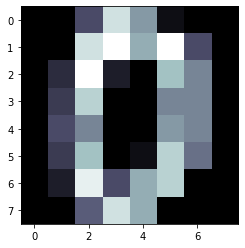

In [3]:
image_pixels = images.shape[1]
image_dim = np.sqrt(image_pixels).astype(int)

first_image = images[0, :].reshape(image_dim, image_dim)
fig = plt.figure()
plt.imshow(first_image, cmap='bone') ## the cmap='bone' is to produce a greyscale image
plt.show()


The `cmap` parameter of `imshow` changes its colour map - you can change this to something else if you prefer a more vibrant range of colours (see [this page](https://matplotlib.org/stable/tutorials/colors/colormaps.html) for more information).

***<span style="color: #ce2227;">TASK 1:</span>*** Create a 5x5 subplot of the first 25 images in the digits problem (i.e., the `images` array in the previous example). Use an enumerator and the `add_subplot()` function to make this easier (see the Tutorial 5 notebook for help on this).

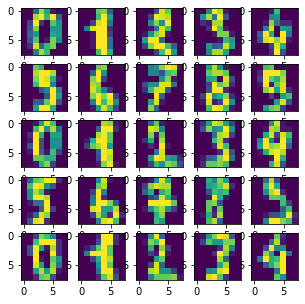

In [62]:
### WRITE YOUR CODE HERE
fig = plt.figure(figsize = (5,5))

for i, img in enumerate(images):
    ax= fig.add_subplot(5,5, i+1)
    plt.imshow(img.reshape(image_dim, image_dim))
    
    
plt.show()

## Recap: Bias, Variance, and the Bias-Variance Decomposition

Let's first restrict ourselves to regression problems (the concept of bias and variance carries over to classification, but is MUCH easier to derive for regression problems). In regression, we typically measure loss (error) as some function of squared loss (e.g., MSE):
$$
MSE = L\left(t, y\right) = \frac{1}{N}\sum_{i=1}^{N}\left(t_{i} - y_{i}\right)^{2}
$$
where $t$ is our target value, and $y$ is the model prediction. Here, we are actually interested in the performance of the learning algorithm, rather than any specific model produced by the algorithm. Therefore, we need to measure performance over $M$ models. We can then define a typical or representative model for our $M$ models. For example, we could consider the mean prediction, $\bar{y}_{i}$:
$$
\bar{y}_{i} = \frac{1}{M}\sum_{j=1}^{M}y_{ij}
$$
which will also have an associated variance:
$$
Var(y_i) = \frac{1}{M}\sum_{j=1}^{M}\left(\bar{y}_{i} - y_{ij}\right)^2
$$

We can then replace the single model prediction $y_i$ in our equation with these two concepts:
\begin{aligned}
L\left(t, y\right) &= \frac{1}{N}\sum_{i=1}^{N}\frac{1}{M}\left(M\left(t_{i} - \bar{y}_{i}\right)^2 + \sum_{j=1}^{M}\left(\bar{y}_{i} - y_{ij}\right)^2\right) \\
                   &= \frac{1}{N}\sum_{i=1}^{N}\left(\left(t_{i} - \bar{y}_{i}\right)^2 + \frac{1}{M}\sum_{j=1}^{M}\left(\bar{y}_{i} - y_{ij}\right)^2\right) \\
                   &= \frac{1}{N}\sum_{i=1}^{N}\left(t_{i} - \bar{y}_{i}\right)^2 + \frac{1}{N}\sum_{i=1}^{N}Var(y_i)
\end{aligned}

We can see that our original loss of mean squared error has been decomposed into two terms: $\frac{1}{N}\sum_{i=1}^{N}\left(t_{i} - \bar{y}_{i}\right)^2$, which is a term that is ***independent of any given model*** (we call this the <span style="color: #ce2227">___bias___</span> term), and $\frac{1}{N}\sum_{i=1}^{N}\frac{1}{M}\sum_{j=1}^{M}\left(\bar{y}_{i} - y_{ij}\right)^2$, which is a term that is ***independent of any test instances*** (we call this the <span style="color: #ce2227">___variance___</span> of the learning method). As we will see, these two terms are usually conflicting in their goals - any attempt to minimise bias will be met with an increase in variance (and vice versa).

***NOTE: it is important to remember that the concepts of bias and variance are used to describe the algorithm behaviour itself, rather than any specific model produced by the algorithm.***

## Data Setup

All of the examples below will use a common set of data. While we could use cross validation to explore the concepts in this lab, the analysis is easier if we can use a set of training samples, and a single representative test set.

We will use a synthetic problem generator for our analysis - scikit-learn provides one such generator as the function [`make_friedman1`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_friedman1.html).

Let's first create a suitable test set:

In [5]:
X_test, t_test = make_friedman1(n_samples=1000, random_state=1234)

Then, we need to create a set of smaller training samples (in this case 50 samples of 100 instances) and store them in the list $M$:

In [6]:
M = [ make_friedman1(n_samples=100, random_state=rng_state) for rng_state in range(50) ]

## Bias and Variance Decomposition of CART

In this section, we walk you through the process of decomposing the error signal of CART into bias and variance. ***You will be expected to perform something similar for ensemble methods in the second assignment***.

Let's start by working out a simple test error for a `DecisionTreeRegressor` over a range of `min_samples_split` using our training samples $M$ and our test set. First, let's define the target hyperparameter values:

In [7]:
examined_minsplits = np.arange(2, 101) ## [ 2, 3, 4, ..., 99, 100 ]

Then, let's compute the test errors:

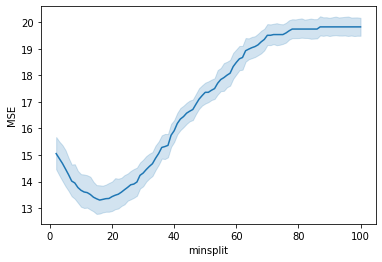

In [8]:
res = []

for m, (X_train, t_train) in enumerate(M):
    for minsplit in examined_minsplits:
        mdl = DecisionTreeRegressor(random_state=0, min_samples_split=minsplit).fit(X_train, t_train)
        y_test = mdl.predict(X_test)
        res.append({ 'minsplit' : minsplit, 'MSE' : mean_squared_error(t_test, y_test) })
res = pd.DataFrame(res)

sns.lineplot(data=res, x='minsplit', y='MSE')
plt.show()

As can be seen, the best value for `minsplit` appears to be around 15-20.  But what is the "nature" of this error? What makes up the error of this best model?

***<span style="color: #ce2227;">TASK 2:</span>*** under which regions of `minsplit` is the decision tree underfitting, and in which regions is it overfitting? How did you work this out?

cannot find out which regions s overfitted/underfitted based on the current data


To complete a bias-variance decomposition, rather than compute the MSE after each set of predictions, we collect them up into a single data frame and compute statistics at the end. Let's start by gathering the required data:

In [9]:
predictions = []

for m, (X_train, t_train) in enumerate(M):
    for minsplit in examined_minsplits:
        mdl = DecisionTreeRegressor(random_state=0, min_samples_split=minsplit).fit(X_train, t_train)
        y_test = mdl.predict(X_test)
        for i, y in enumerate(y_test):
            predictions.append({ 'minsplit' : minsplit, 'i': i, 'y' : y })
predictions = pd.DataFrame(predictions)
display(predictions)

,minsplit,i,y
0,2,0,11.816621
1,2,1,18.416216
2,2,2,11.448695
3,2,3,10.228390
4,2,4,18.079764
...,...,...,...
4949995,100,995,16.366575
4949996,100,996,10.332843
4949997,100,997,16.366575
4949998,100,998,10.332843


As you can see, we've generated a LOT of points for this. However, the computation from here is (relatively) straightforward. First, we need to extract the "mean" prediction for our learning algorithm on ech test instance. Because we have the data in a data frame, this can be done by grouping and aggregating:

In [10]:
ybar = predictions.groupby([ 'minsplit', 'i' ]).agg(ybar=('y', 'mean')).reset_index()
display(ybar)

,minsplit,i,ybar
0,2,0,15.362833
1,2,1,17.453140
2,2,2,15.189404
3,2,3,14.076430
4,2,4,12.689638
...,...,...,...
98995,100,995,13.888253
98996,100,996,12.202084
98997,100,997,16.910236
98998,100,998,12.505869


We also need a data frame of target values so that we can compute the required stats:

In [11]:
t = pd.DataFrame({ 'i' : range(len(t_test)), 't' : t_test })
display(t)

,i,t
0,0,15.487307
1,1,14.990197
2,2,18.443673
3,3,16.072043
4,4,14.165877
...,...,...
995,995,11.051109
996,996,13.160215
997,997,19.736977
998,998,15.752805


Now, to compute the bias-variance decomposition, we first join our raw predictions, mean predictions, and targets into a single data frame:

In [12]:
decomp = predictions.merge(ybar, on=[ 'minsplit', 'i' ]).merge(t, on='i')
decomp

,minsplit,i,y,ybar,t
0,2,0,11.816621,15.362833,15.487307
1,2,0,14.011984,15.362833,15.487307
2,2,0,10.688237,15.362833,15.487307
3,2,0,17.106745,15.362833,15.487307
4,2,0,16.108148,15.362833,15.487307
...,...,...,...,...,...
4949995,100,999,10.732669,15.638989,8.428744
4949996,100,999,15.242237,15.638989,8.428744
4949997,100,999,17.366434,15.638989,8.428744
4949998,100,999,18.115306,15.638989,8.428744


We can then compute and add the required fields for total error (MSE), bias and variance:

In [13]:
decomp['mse'] = (decomp['t'] - decomp['y'])**2      ## total error (MSE - target - raw prediction)
decomp['bias'] = (decomp['t'] - decomp['ybar'])**2  ## bias (target - mean prediction)
decomp['var'] = (decomp['y'] - decomp['ybar'])**2   ## variance

and from this data frame, we can group by the hyperparameter `minsplit` and compute the stats:

In [14]:
decomp = decomp.groupby('minsplit').agg({ 'mse' : np.mean, 'bias' : np.mean, 'var' : np.mean }).reset_index()
decomp

,minsplit,mse,bias,var
0,2,15.052876,4.928590,10.124286
1,3,14.868904,4.914693,9.954211
2,4,14.687111,4.853613,9.833498
3,5,14.473490,4.862059,9.611431
4,6,14.255720,4.943877,9.311843
...,...,...,...,...
94,96,19.832699,15.656519,4.176179
95,97,19.832699,15.656519,4.176179
96,98,19.832699,15.656519,4.176179
97,99,19.832699,15.656519,4.176179


And now we can analyse the results, for example via a plot:

The best minsplit value in terms of MSE is: 16


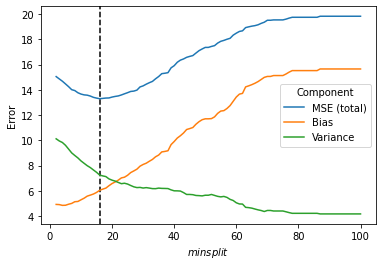

In [15]:
best_minsplit = decomp[decomp['mse']==decomp['mse'].min()]['minsplit'].values[0] ## identify the best minsplit value by the row with the lowest MSE
print(f'The best minsplit value in terms of MSE is: {best_minsplit}')

sns.lineplot(data=decomp.melt(id_vars='minsplit'), x='minsplit', y='value', hue='variable').set(xlabel='$minsplit$', ylabel='Error')
plt.axvline(x=best_minsplit, c='black', linestyle='--', zorder=1)
plt.legend(title='Component', labels=['MSE (total)', 'Bias', 'Variance'])
plt.show()

As can be seen, the best value for `minsplit`, according to total error (MSE) again appears to be around 15-20.  But what is the "nature" of this error? What makes up the error of this best model?

***<span style="color: #ce2227;">TASK 3:</span>*** Based on the additional information of bias and variance, under which regions of `minsplit` is the decision tree underfitting, and in which regions is it overfitting?

as shown on the graph the more minsplit means the higher mse and bias so when it gets to that point, the minsplit is overfitted but as shown at the start of the graph, error is high showing that it is under fitted so when the error on average is high at the start it is underfitted and when the error is high towards the end it is overfitted.

___The whole process of decomposing error into bias and variance is repeated below in one cell___

The best minsplit value in terms of MSE is: 16


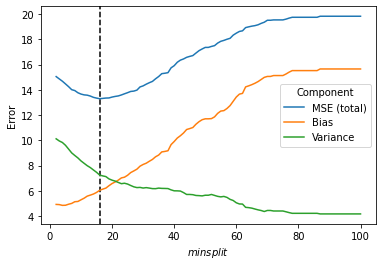

In [16]:
predictions = []

for m, (X_train, t_train) in enumerate(M):
    for minsplit in examined_minsplits:
        mdl = DecisionTreeRegressor(random_state=0, min_samples_split=minsplit).fit(X_train, t_train)
        y_test = mdl.predict(X_test)
        for i, y in enumerate(y_test):
            predictions.append({ 'minsplit' : minsplit, 'i': i, 'y' : y })
predictions = pd.DataFrame(predictions)

ybar = predictions.groupby([ 'minsplit', 'i' ]).agg(ybar=('y', 'mean')).reset_index()
t = pd.DataFrame({ 'i' : range(len(t_test)), 't' : t_test })

decomp = predictions.merge(ybar, on=[ 'minsplit', 'i' ]).merge(t, on='i')

decomp['mse'] = (decomp['t'] - decomp['y'])**2      ## total error (MSE - target - raw prediction)
decomp['bias'] = (decomp['t'] - decomp['ybar'])**2  ## bias (target - mean prediction)
decomp['var'] = (decomp['y'] - decomp['ybar'])**2   ## variance

decomp = decomp.groupby('minsplit').agg({ 'mse' : np.mean, 'bias' : np.mean, 'var' : np.mean }).reset_index()

best_minsplit = decomp[decomp['mse']==decomp['mse'].min()]['minsplit'].values[0] ## identify the best minsplit value by the row with the lowest MSE
print(f'The best minsplit value in terms of MSE is: {best_minsplit}')

sns.lineplot(data=decomp.melt(id_vars='minsplit'), x='minsplit', y='value', hue='variable').set(xlabel='$minsplit$', ylabel='Error')
plt.axvline(x=best_minsplit, c='black', linestyle='--', zorder=1)
plt.legend(title='Component', labels=['MSE (total)', 'Bias', 'Variance'])
plt.show()

This whole process can be used as a template for measuring the bias and variance of any learning method. This might come in handy later in the lab, and for the second assignment.

## Precursor - generating a bootstrap sample

A bootstrap sample is simply a sample from a population with replacement. In other words, if we have a set of $N$ things, we simply sample from this set $N$ times, with replacement (i.e., we may sample the same thing from the set multiple times).

Generating a bootstrap sample is fairly straightforward if we use numpy's [choice](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) operator. We start by defining a random number generator:

In [17]:
rng = np.random.default_rng(seed=1234) ## as always, the seed is to make the random sequence repeatible

Then, if we have a set `S`, we generate a bootstrap sample as follows:

In [18]:
S = np.array([ 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j' ])
N = len(S)
B = rng.choice(N, size=N, replace=True)
print(S)
print(S[B])

['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j']
['j' 'j' 'j' 'd' 'b' 'j' 'b' 'c' 'b' 'd']


Notice that some instances are sampled multiple times, while others are missed out.

So, for a given training set `X` and `t` (of size `N`), we bootstrap sample as follows:

In [19]:
X_train, t_train = M[0] ## get the first of our training samples, it could be any of them.

N = len(X_train)
B = rng.choice(N, size=N, replace=True)

X_boot, t_boot = X_train[B, :], t_train[B]

Now, we can build a model on `X_boot` and `t_boot`, just as before. However, if the learning method is _unstable_ (i.e., it builds a different model in response to a different data sample), then we can expect the resulting model to be somewhat different than the model that would have been built from the original data set. We will use this idea to our advantage in the next step when creating bagging ensembles.

## Roll Your Own Ensemble: Bagging

In the previous step, we developed $M$ models, each trainined on a separate set of data, and used this to compute the bias and variance of the learning method. An interesting thing happens if we try to aggregate those models into a single prediction, rather than keeping them separate. Let's look at what happens if we combine the model predictions:

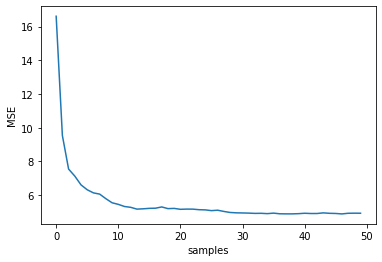

In [20]:
mdl = DecisionTreeRegressor(min_samples_split=2, random_state=0)

perf = []

y_test = np.zeros(len(t_test)) ## start with a container to hold the aggregate predictions.
for i, (X_train, t_train) in enumerate(M):
    mdl.fit(X_train, t_train)
    y_test += (mdl.predict(X_test) - y_test) / (i + 1) # update the average prediction with the predictions of the latest model
    perf.append({ 'samples' : i, 'MSE' : mean_squared_error(t_test, y_test) })

perf = pd.DataFrame(perf)

sns.lineplot(data=perf, x='samples', y='MSE')
plt.show()

Notice that, as we increase the number of prediction models, our total error decreases.

Let's repeat this task, but this time include the error of each individual model as we go:

***<span style="color: #ce2227;">TASK 4:</span>*** Repeat the aggregation task above, but include the individual model error at each step:

{'samples': 0, 'MSE': 16.615555362979}
{'samples': 1, 'MSE': 9.539887108283827}
{'samples': 2, 'MSE': 7.548910409040847}
{'samples': 3, 'MSE': 7.130784884049002}
{'samples': 4, 'MSE': 6.610117458665732}
{'samples': 5, 'MSE': 6.320499468643297}
{'samples': 6, 'MSE': 6.135784101153793}
{'samples': 7, 'MSE': 6.063093867601095}
{'samples': 8, 'MSE': 5.792108943593496}
{'samples': 9, 'MSE': 5.548747028093164}
{'samples': 10, 'MSE': 5.4550622062370495}
{'samples': 11, 'MSE': 5.328057956310506}
{'samples': 12, 'MSE': 5.278611801031932}
{'samples': 13, 'MSE': 5.172321472282837}
{'samples': 14, 'MSE': 5.190920613587586}
{'samples': 15, 'MSE': 5.217810958177861}
{'samples': 16, 'MSE': 5.227196256437129}
{'samples': 17, 'MSE': 5.301774180271685}
{'samples': 18, 'MSE': 5.201368869440301}
{'samples': 19, 'MSE': 5.21509488135634}
{'samples': 20, 'MSE': 5.1609982668281145}
{'samples': 21, 'MSE': 5.173301052632749}
{'samples': 22, 'MSE': 5.171132620399856}
{'samples': 23, 'MSE': 5.13796547378605}
{'sa

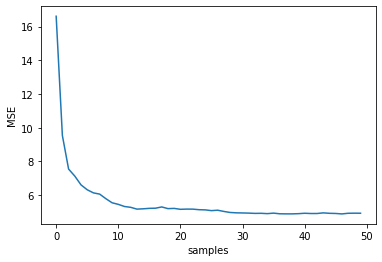

In [63]:
mdl = DecisionTreeRegressor(min_samples_split=2, random_state=0)

perf = []

y_test = np.zeros(len(t_test)) ## start with a container to hold the aggregate predictions.
for i, (X_train, t_train) in enumerate(M):
    mdl.fit(X_train, t_train)
    y_test += (mdl.predict(X_test) - y_test) / (i + 1) # update the average prediction with the predictions of the latest model
    perf.append({ 'samples' : i, 'MSE' : mean_squared_error(t_test, y_test) })
    print(({ 'samples' : i, 'MSE' : mean_squared_error(t_test, y_test) }))

perf = pd.DataFrame(perf)

sns.lineplot(data=perf, x='samples', y='MSE')
plt.show()

If you have done this correctly, you should see that the individual errors all hover around a common value (typically around 12-16), but their error is greatly reduced when aggregated. ___<span style='color: #ce2227'>Why do you think this is?</span>___

### Bagging
In this section, you will write code to implement your own version of bagging. Specifically, you will create a collection of CART learners, each trained on a different resample with replacement of the training data (a ***booststrap*** sample) and parameterised to overfit to the training sample. By averaging the predictions of the ensemble members, we expect their errors in overfitting to their specific training sample will cancel each other out, leaving a more accurate aggregate prediction.

In the previous section you aggregated multiple models trained on multiple samples to reduce error. However, we usually don't have access to multiple sets of data, we're given a single set of data for training. However, we can use the concept of a bootstrap to simulate having multiple data sets at our disposal. Let's modify the above example slightly, so that it uses only one set of data but generates multiple bootstrap samples from it:


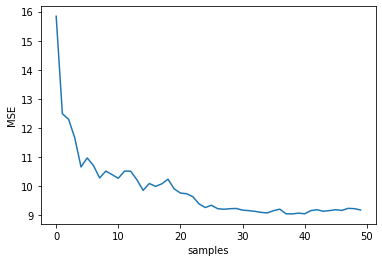

In [22]:
rnd = np.random.default_rng(seed=1234)
mdl = DecisionTreeRegressor(min_samples_split=2, random_state=0)

perf = []

X_train, t_train = M[0]

n_boot = len(M) ## number of bootstrap samples to obtain

y_test = np.zeros(len(t_test)) ## start with a container to hold the aggregate predictions.
for i in range(n_boot):
    B = rng.choice(len(X_train), len(X_train), replace=True)
    X_boot, t_boot = X_train[B, :], t_train[B]
    mdl.fit(X_boot, t_boot)
    y_test += (mdl.predict(X_test) - y_test) / (i + 1) # update the average prediction with the predictions of the latest model
    perf.append({ 'samples' : i, 'MSE' : mean_squared_error(t_test, y_test) })

perf = pd.DataFrame(perf)

sns.lineplot(data=perf, x='samples', y='MSE')
plt.show()

Notice that we get a similar reduction of error, as before, even if the overall reduction in error isn't quite so large.

What you have performed here is called ___bootstrap aggregation___ (or ___bagging___). The general algorithm for building a bagging ensemble is remarkedly simple. Given a training sample $train$ of size $N$:
1. Create an empty list $ens$ for the ensemble
2. For the required number of trees:  
  2.1. Sample with replacemment $N$ instances from $train$ to create the bootstrap $B$  
  2.2. Build a model $m_B$ on $B$ and add the model to the $ens$ list.

Then, when we wish to predict from this ensemble, we simply average the individual predictions from the models within the ensemble.


The process of using decision trees in combination with bagging has proven so effective that it has its own name - ___Random Forests___. There's even a method available in scikit-learn to encapsulate this, called a [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html). Let's see how that works (we'll examine it over a range of ensemble sizes):

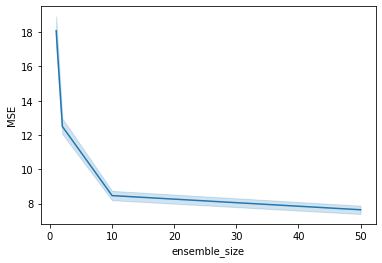

In [23]:
perf = []

n_boot = [ 1, 2, 10, 50 ]

for i, (X_train, t_train) in enumerate(M):
    for n_est in n_boot:
        mdl = RandomForestRegressor(n_estimators=n_est, min_samples_split=2, random_state=0, n_jobs=-1).fit(X_train, t_train)
        y_test = mdl.predict(X_test)
        perf.append({ 'ensemble_size' : n_est, 'MSE' : mean_squared_error(t_test, y_test) })

perf = pd.DataFrame(perf)

sns.lineplot(data=perf, x='ensemble_size', y='MSE')
plt.show()

As you can see, the performance of the Random Forest essentially replicates our manual process that we performed earler.


***<span style='color: #ce2227'>TASK 5:</span>*** Why do we construct the ensemble base learners with a `min_samples_split` of 2? (hint, look back to the bias and variance results of the previous section)

if we are trying to eliminate the bias so we select the area with the lowest bias and this would be the minsampleplit of 2 and would be the best for a ensample base learner.

Now that you have a Random Forest model available, it would be a good idea to understand its bias and variance characteristics.

***<span style='color: #ce2227'>TASK 6:</span>*** Modify the bias-variance decomposition example from earlier so that it explores the bias and variance characteristics of Random Forests. Explore the `n_estimators` hyperparameter at the points [ 1, 2, 3, 5, 10, 20, 30, 50 ]

The best N_esimators value in terms of MSE is: 50


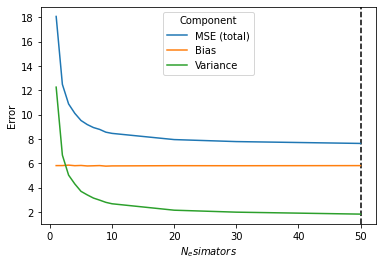

In [75]:
predictions = []
N_esimators = [1,2,3,4,5,6,7,8,9,10,20,30,50]

for m, (X_train, t_train) in enumerate(M):
    for n in N_esimators:
        mdl = RandomForestRegressor(n_estimators=n, min_samples_split=2, random_state = 0, n_jobs = -1).fit(X_train, t_train)
        y_test = mdl.predict(X_test)
        for i, y in enumerate(y_test):
            predictions.append({ 'N_esimators' : n, 'i': i, 'y' : y })
predictions = pd.DataFrame(predictions)

ybar = predictions.groupby([ 'N_esimators', 'i' ]).agg(ybar=('y', 'mean')).reset_index()
t = pd.DataFrame({ 'i' : range(len(t_test)), 't' : t_test })

decomp = predictions.merge(ybar, on=[ 'N_esimators', 'i' ]).merge(t, on='i')

decomp['mse'] = (decomp['t'] - decomp['y'])**2      ## total error (MSE - target - raw prediction)
decomp['bias'] = (decomp['t'] - decomp['ybar'])**2  ## bias (target - mean prediction)
decomp['var'] = (decomp['y'] - decomp['ybar'])**2   ## variance

decomp = decomp.groupby('N_esimators').agg({ 'mse' : np.mean, 'bias' : np.mean, 'var' : np.mean }).reset_index()

best_minsplit = decomp[decomp['mse']==decomp['mse'].min()]['N_esimators'].values[0] ## identify the best minsplit value by the row with the lowest MSE
print(f'The best N_esimators value in terms of MSE is: {best_minsplit}')

sns.lineplot(data=decomp.melt(id_vars='N_esimators'), x='N_esimators', y='value', hue='variable').set(xlabel='$N_esimators$', ylabel='Error')
plt.axvline(x=best_minsplit, c='black', linestyle='--', zorder=1)
plt.legend(title='Component', labels=['MSE (total)', 'Bias', 'Variance'])
plt.show()

***<span style='color: #ce2227'>TASK 7:</span>*** Compare the bias error of the random forest with an ensemble size of 1 to that of the single decision tree with `minsplit` of 2. What difference to you note, and why do you think this might be?

the bias error of the in this graph is constant and in the single decision tree with minsplit of 2 it is changing and growing. Even though the random forest has slightly higher bias an ensamble of 2, it stays constant throughout and doesnt increase like the single decision tree

***<span style='color: #ce2227'>TASK 8:</span>*** How has a random forest regressor managed to reduce error over that of a single model?

Have more number of estimators which on average the more estimors the mroe accurate and less error. 

## Roll Your Own Ensemble: Boosting

As mentioned in lectures, boosting is an alternative form of ensemble learning to bagging that focuses on a different type of model aggregation. In contrast to bagging, boosting takes a completely different approach to ensemble learning by taking a "weak" base learning and chaining them together to build upon predictions of the previous model(s).

The variant of boosting that you will be constructing is called [gradient boosting](https://en.wikipedia.org/wiki/Gradient_boosting#:~:text=Gradient%20boosting%20is%20a%20machine,prediction%20models%2C%20typically%20decision%20trees.).


Let's start with a training sample:

In [25]:
X_train, t_train = M[0]

We'll also define an initial "model" for the data (we'll make this the mean of the training response), and a residual `r`. You can think of this as the remainder of the target that the previous model(s) didn't capture.

In [26]:
r0 = np.mean(t_train)
r_train = t_train - r0

Now, for the next model that we build, we will fit it to the our training features and the ___current residuals___

In [27]:
r1 = DecisionTreeRegressor(min_samples_split=100, random_state=0).fit(X_train, r_train)

Then, we update the residuals to factor this new model:

In [28]:
r_train = r_train - r1.predict(X_train)

And then we keep doing this until we've run out of time.

In [29]:
r2 = DecisionTreeRegressor(min_samples_split=100, random_state=0).fit(X_train, r_train)
r_train = r_train - r2.predict(X_train)

r3 = DecisionTreeRegressor(min_samples_split=100, random_state=0).fit(X_train, r_train)
r_train = r_train - r3.predict(X_train)

## AND SO ON ...


 Predictions of the model then become a summation of the individual model predictions:

In [30]:
y_test = np.repeat(r0, len(t_test)) ## initial model
print(mean_squared_error(t_test, y_test))

y_test = r0 + r1.predict(X_test) ## initial model combined with first model
print(mean_squared_error(t_test, y_test))

y_test = r0 + r1.predict(X_test) + r2.predict(X_test) ## next model factored
print(mean_squared_error(t_test, y_test))

y_test = r0 + r1.predict(X_test) + r2.predict(X_test) + r3.predict(X_test) ### AND SO ON
print(mean_squared_error(t_test, y_test))

24.32054200232204
20.330368304795357
19.428065467326313
19.25679201213971


As you can see, the incremental building of the ensemble leads to improvement in model performance over time. Sometimes, to smooth out the learning process, we weight each new model with a parameter `eta``. This is a form of _regularisation_. (we'll do this in the next example)

As you can imagine, the repetitive process of building the boosting ensemble can be wrapped into a loop:

<AxesSubplot:xlabel='n_trees', ylabel='MSE'>

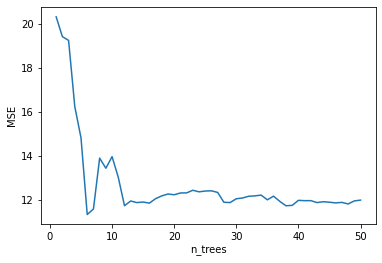

In [31]:
min_samples_split = 100
n_trees = 50

perf = []

r0 = np.mean(t_train)
r_train  = t_train - r0
ens = []

y_test = np.repeat(r0, len(X_test))
for i in range(n_trees):
    mdl = DecisionTreeRegressor(random_state=0, min_samples_split=min_samples_split).fit(X_train, r_train)
    ens.append(mdl) ## add the new model to the ensemble
    r_train -= mdl.predict(X_train)

    y_test += mdl.predict(X_test) ## update the test predictions with the weighted version of the new model's predictions
    perf.append({ 'n_trees' : i + 1, 'MSE' : mean_squared_error(t_test, y_test) })

perf = pd.DataFrame(perf)

sns.lineplot(data=perf, x='n_trees', y='MSE')

As you can see, the (general) trend is for the test error to reduce as the ensemble size increases

***<span style='color: #ce2227'>TASK 9:</span>*** Why do we construct the boosting ensemble base learners with a `min_samples_split` of 100? (Hint: contrast this to the bagging example using `min_samples_split` of 2)

because with a min_sample_split of 100 you would have a high bias and low variance (opposite of bagging). and combines a set of weak learners into a strong learner to minimize training error.


***<span style='color: #ce2227'>TASK 10:</span>*** Modify the above code so that the model predictions are weighted by a parameter `eta`. (Hint: modify each line where `predict` is called such that it is multiplied by `eta`) Set the value of `eta` to 0.1. Observe the differences from before - why do you think this is happening?

<AxesSubplot:xlabel='n_trees', ylabel='MSE'>

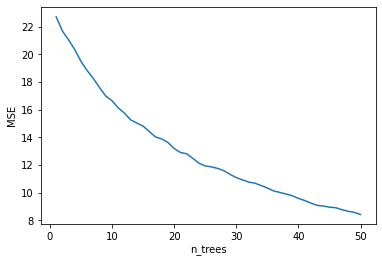

In [77]:
min_samples_split = 100
n_trees = 50
eta = 0.1
perf = []

r0 = np.mean(t_train)
r_train  = t_train - r0
ens = []

y_test = np.repeat(r0, len(X_test))
for i in range(n_trees):
    mdl = DecisionTreeRegressor(random_state=0, min_samples_split=min_samples_split).fit(X_train, r_train)
    ens.append(mdl) ## add the new model to the ensemble
    r_train -= mdl.predict(X_train)*eta

    y_test += mdl.predict(X_test)*eta  ## update the test predictions with the weighted version of the new model's predictions
    perf.append({ 'n_trees' : i + 1, 'MSE' : mean_squared_error(t_test, y_test) })

perf = pd.DataFrame(perf)

sns.lineplot(data=perf, x='n_trees', y='MSE')

Trying to lower the rate we add new information in. So it slowly lowers the MSE compared to above where it drops quite a lot at the start but then the progress starts platau and the data becomes noisy. But this graph on the other hand slowly decreases the MSE with the N_trees as the updates are weighted by 0.1.

### Off-the-shelf boosting: Gradient Boosting Machine

The previous section tasked you with constructing a boosting ensemble. Like with bagging, it is useful to see how such an ensemble is constructed. However, it is also better to leverage boosting off-the-shelf through a solution called [gradient boosting](https://en.wikipedia.org/wiki/Gradient_boosting#:~:text=Gradient%20boosting%20is%20a%20machine,prediction%20models%2C%20typically%20decision%20trees.). scikit-learn provides this through the [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) class:

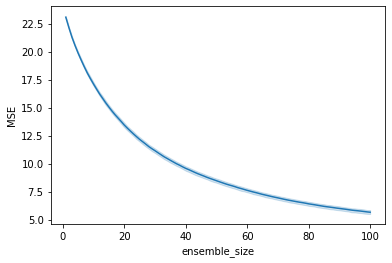

In [33]:
perf = []

n_tree = np.arange(1, 101).astype(int)

for i, (X_train, t_train) in enumerate(M):
    for n_est in n_tree:
        mdl = GradientBoostingRegressor(n_estimators=n_est, min_samples_split=100, learning_rate=0.1, random_state=0).fit(X_train, t_train)
        y_test = mdl.predict(X_test)
        perf.append({ 'ensemble_size' : n_est, 'MSE' : mean_squared_error(t_test, y_test) })

perf = pd.DataFrame(perf)

sns.lineplot(data=perf, x='ensemble_size', y='MSE')
plt.show()

As you can see, the results seem to encapsulate the manual process nicely. (in fact, it's performance is actually slightly better due to a couple of optimisation not discussed here!)

## Wrap-Up

In this lab, you have seen how two forms of ensemble learning - bagging and boosting - can be used to provide more accurate predictions from a base learner. In the second assignment, you will explore these methods further to better understand how they work to reduce error.

***OPTIONAL TASK 10:*** As a precursor to completing your second assignment, examine the bias and variance decomposition of CART done at the start of this lab. Perform a bias and variance decomposition of gradient boosting In particular, relate the bias and variance conditions of CART for a given value of `min_samples_split` to the parameterisation of CART when used in bagging and boosting. From this relationship, make an educated guess as to what components of error are targeted for reduction by bagging and boosting.

_WRITE YOUR ANSWER HERE_